In [1]:
import matplotlib.pyplot as plt
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np


from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor


from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler


In [12]:
data = pd.read_csv("../Merging/Merged_Data.csv")
unsup = pd.read_csv("../Analysis/Plant_Clusters.csv")
data = data.merge(unsup, on='plantCode', how='left').fillna(0)
print(data.columns)
data.head(5)

Index(['period', 'plantCode', 'plantName', 'fuel2002', 'fuelTypeDescription',
       'state', 'stateDescription', 'primeMover', 'total-consumption',
       'total-consumption-units',
       ...
       'KM8_6', 'KM8_7', 'H8_0', 'H8_1', 'H8_2', 'H8_3', 'H8_4', 'H8_5',
       'H8_6', 'H8_7'],
      dtype='object', length=111)


,period,plantCode,plantName,fuel2002,fuelTypeDescription,state,stateDescription,primeMover,total-consumption,total-consumption-units,...,KM8_6,KM8_7,H8_0,H8_1,H8_2,H8_3,H8_4,H8_5,H8_6,H8_7
0,2020-01-01,57950,MSC Croswell,NG,Natural Gas,MI,Michigan,ALL,84432,MMBtu per Mcf,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2020-12-01,57950,MSC Croswell,NG,Natural Gas,MI,Michigan,ALL,11343,MMBtu per Mcf,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2023-08-01,57950,MSC Croswell,NG,Natural Gas,MI,Michigan,ALL,109965,MMBtu per Mcf,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2023-04-01,57950,MSC Croswell,NG,Natural Gas,MI,Michigan,ALL,12548,MMBtu per Mcf,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2023-02-01,57950,MSC Croswell,NG,Natural Gas,MI,Michigan,ALL,96587,MMBtu per Mcf,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [13]:

data['period'] = pd.to_datetime(data['period'])
data.sort_values(by='period', inplace=True)
plant_codes = data['plantCode'].unique()
data = data[data['period'] >= '2019-01-01']

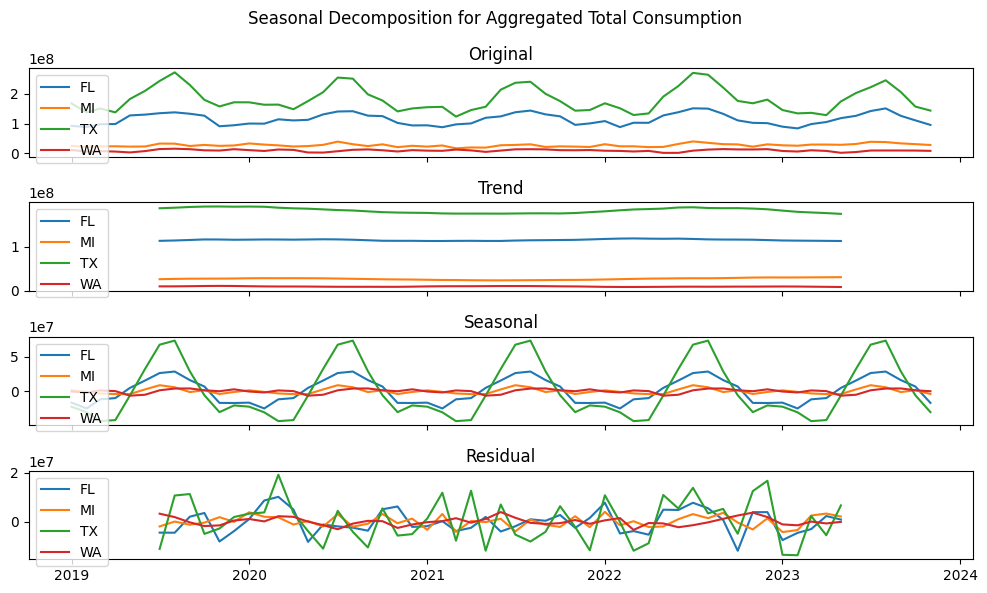

In [14]:
# Convert 'period' column to datetime
data['period'] = pd.to_datetime(data['period'])

# Group by 'period' and 'state', then sum 'total-consumption'
aggregated_data = data.groupby(['period', 'state'])['total-consumption'].sum().unstack().fillna(0)

# Perform seasonal decomposition on each state's total consumption
results = {}
for state, consumption in aggregated_data.items():
    result = seasonal_decompose(consumption, model='additive', period=12)
    results[state] = result

# Plot the decomposed components for aggregated total consumption of each state
fig, axs = plt.subplots(4, 1, figsize=(10, 6), sharex=True)

for state, result in results.items():
    trend = result.trend
    seasonal = result.seasonal
    residual = result.resid

    axs[0].plot(aggregated_data.index, aggregated_data[state], label=state)
    axs[1].plot(trend, label=state)
    axs[2].plot(seasonal, label=state)
    axs[3].plot(residual, label=state)

axs[0].set_title("Original")
axs[1].set_title("Trend")
axs[2].set_title("Seasonal")
axs[3].set_title("Residual")

for ax in axs:
    ax.legend(loc='upper left')

plt.suptitle("Seasonal Decomposition for Aggregated Total Consumption")
plt.tight_layout()
plt.show()

# plot on separate axes

In [15]:
# Define the time periods and features for training and testing
start_train = '2019-01-01'
end_train = '2022-12-31'
start_test = '2023-01-01'
end_test = '2023-12-31'
model_features = ['ELEVATION', 'TEMP',
       'WDSP', 'MXSPD', 'GUST', 'MAX', 'MIN', 'PRCP', 'SNDP','TEMPEXT_BASE40', 'TEMPEXT_BASE45', 'TEMPEXT_BASE50', 
       'OVER_60', 'OVER_70', 'OVER_80', 'UNDER_40', 'UNDER_30', 'UNDER_20',
       'SUM_OVER_UNDER', 'LATITUDE','LONGITUDE','Zip','plantCode',
       'N_KM8_0','N_KM8_1','N_KM8_2','N_KM8_3','N_KM8_4','N_KM8_5','N_KM8_6','N_KM8_7','N_H8_0',
       'N_H8_1','N_H8_2','N_H8_3','N_H8_4','N_H8_5','N_H8_6','N_H8_7','KM8_0','KM8_1','KM8_2','KM8_3',
       'KM8_4','KM8_5','KM8_6','KM8_7','H8_0','H8_1','H8_2','H8_3','H8_4','H8_5','H8_6','H8_7']

print(data[model_features].head())

       ELEVATION       TEMP      WDSP      MXSPD       GUST        MAX  \
15891       11.0  52.854839  6.587097  11.509677   0.000000  60.874194   
20500        3.5  69.029032  8.190323  12.958065   0.000000  74.422581   
17705        7.0  56.264516  3.254839   9.187097   0.000000  63.919355   
13435       30.5  52.141935  5.370968  11.825806  10.464516  63.835484   
506        206.5  23.809677  8.809677  15.496774  18.154839  31.322581   

             MIN      PRCP  SNDP  TEMPEXT_BASE40  ...  KM8_6  KM8_7  H8_0  \
15891  46.848387  0.000000   0.0       12.854839  ...    0.0    0.0   0.0   
20500  64.070968  0.000000   0.0       29.029032  ...    0.0    1.0   0.0   
17705  50.429032  0.000000   0.0       16.264516  ...    0.0    0.0   0.0   
13435  43.796774  0.073871   0.0       12.141935  ...    0.0    0.0   0.0   
506    16.512903  0.067742   0.0       16.287097  ...    0.0    0.0   0.0   

       H8_1  H8_2  H8_3  H8_4  H8_5  H8_6  H8_7  
15891   0.0   0.0   0.0   0.0   0.0   0.0 

In [16]:
# How to do cross validation folds? Feature ablation
# For cross validation: could do (4 different folds, increasing data (year 1, year 1-2, year 1-3, year 1-4))

def train_test_and_plot(data, model, start_train, end_train, start_test, end_test, model_features):
    # Exclude negative consumption values
    data = data[data['total-consumption'] > 0]

    # Convert 'state' column to categorical type
    data['state'] = data['state'].astype('category')
    
    # Extract features and target variable
    X = data[model_features].fillna(0)
    y = data['total-consumption']

    # Filter the data for training and testing
    train_data = data[(data['period'] >= start_train) & (data['period'] <= end_train)]
    test_data = data[(data['period'] >= start_test) & (data['period'] <= end_test)]

    # Extract features and target variable for training
    X_train = train_data[model_features]
    y_train = train_data['total-consumption']

    # Extract features and target variable for testing
    X_test = test_data[model_features]
    y_test = test_data['total-consumption']

    # Fit the model on the training data
    model.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred = model.predict(X_test)

    # Evaluate the model
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    # Could use mean absolute error as an option (evaluating against the median instead of the average)
    # Reasonable baseline approach to use a combination of a squared error and R2 terms

    print('Model evaluation:')
    print(f'Mean Squared Error: {mse}')
    print(f'R-squared: {r2}')

    # Plotting the predicted vs. actual total consumption
    plt.figure(figsize=(12, 6))
    plt.scatter(y_test, y_pred, c=test_data['state'].cat.codes, cmap='viridis', alpha=0.5)
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'k--', lw=2)  # Plotting the diagonal line
    plt.title('Predicted vs. Actual Total Consumption')
    plt.xlabel('Actual Total Consumption')
    plt.ylabel('Predicted Total Consumption')
    plt.grid(True)

    plt.show()


    # Plotting predicted and actual values against timescale 'period'
    plt.figure(figsize=(12, 6))
    plt.scatter(test_data['period'], y_test, label='Actual', alpha=0.5)
    plt.scatter(test_data['period'], y_pred, label='Predicted', alpha=0.5)
    plt.title('Actual vs. Predicted Total Consumption Over Time')
    plt.xlabel('Period')
    plt.ylabel('Total Consumption')
    plt.xticks(rotation=45)
    plt.legend()
    plt.grid(True)
    plt.show()


    # Perform PCA on the entire dataset
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    pca = PCA(n_components=20)  # Specify the number of components to retain
    pca.fit(X_scaled)

    # Visualize explained variance ratio
    plt.figure(figsize=(8, 5))
    plt.bar(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_, alpha=0.5, align='center')
    plt.step(range(1, len(pca.explained_variance_ratio_) + 1), np.cumsum(pca.explained_variance_ratio_), where='mid')
    plt.xlabel('Number of Components')
    plt.ylabel('Explained Variance Ratio')
    plt.title('Explained Variance Ratio by Principal Components')
    plt.show()

    # Feature Importance
    if hasattr(model, 'feature_importances_'):
        feature_importance = model.feature_importances_
        sorted_idx = np.argsort(feature_importance)
        top_features = np.array(model_features)[sorted_idx][-10:]  # Adjust the number of top features as needed
        pos = np.arange(top_features.shape[0]) + .5
        plt.figure(figsize=(10, 6))
        plt.barh(pos, feature_importance[sorted_idx][-10:], align='center')
        plt.yticks(pos, top_features)
        plt.xlabel('Feature Importance')
        plt.title('Top 10 Feature Importance')
        plt.show()

C:\Users\nicoesse\AppData\Local\Temp\ipykernel_25388\1824536124.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['state'] = data['state'].astype('category')


Model evaluation:
Mean Squared Error: 506834930181.35516
R-squared: 0.869352189883775


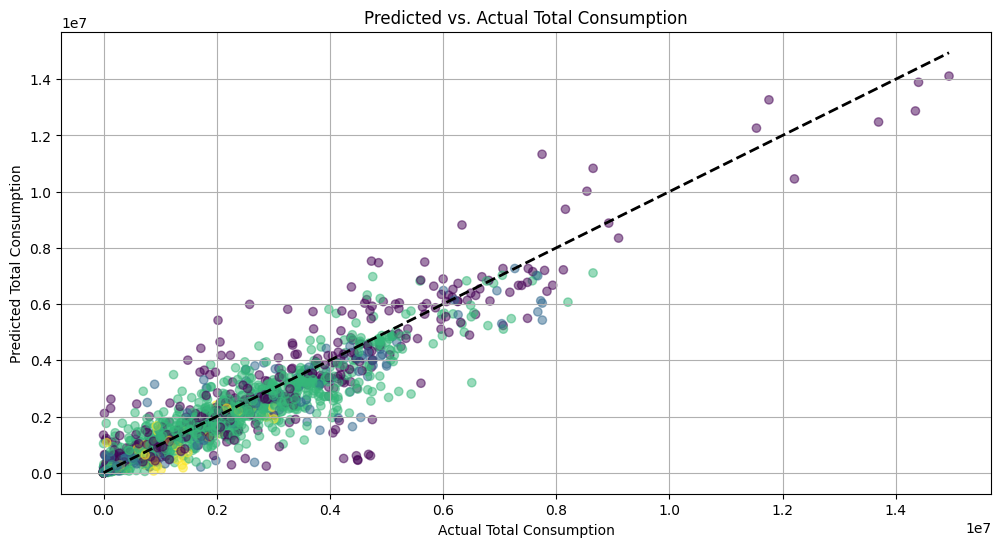

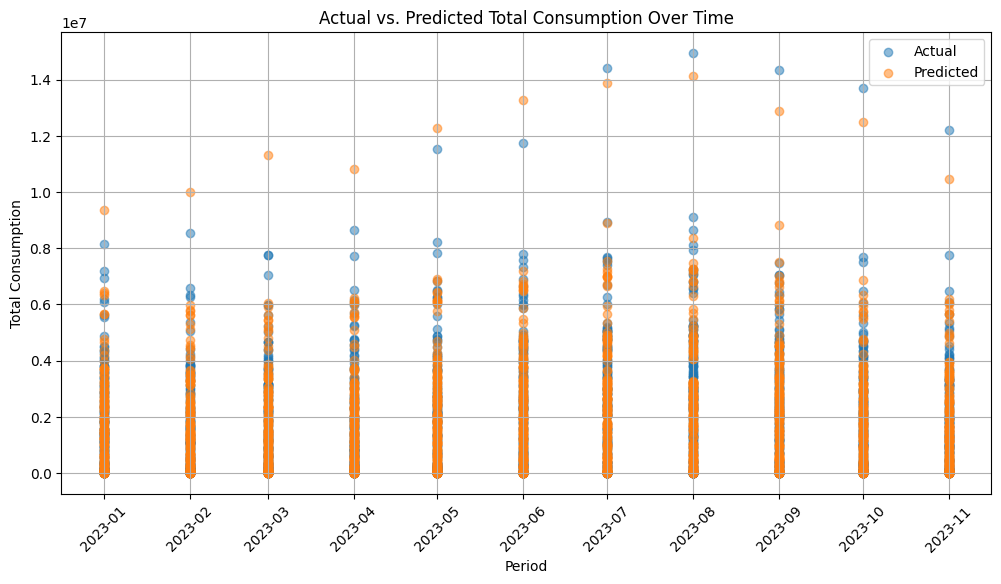

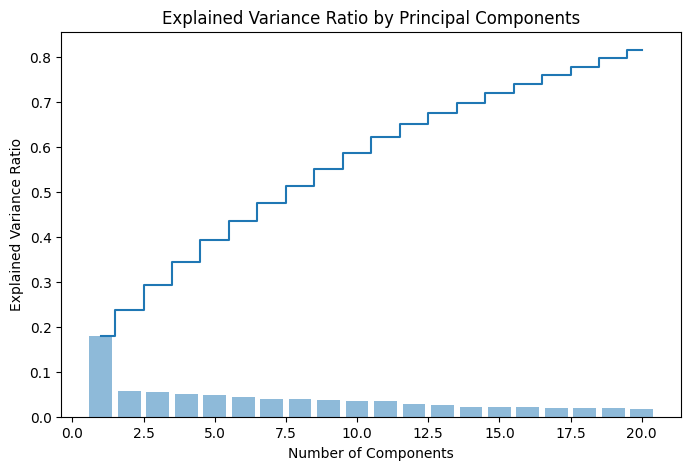

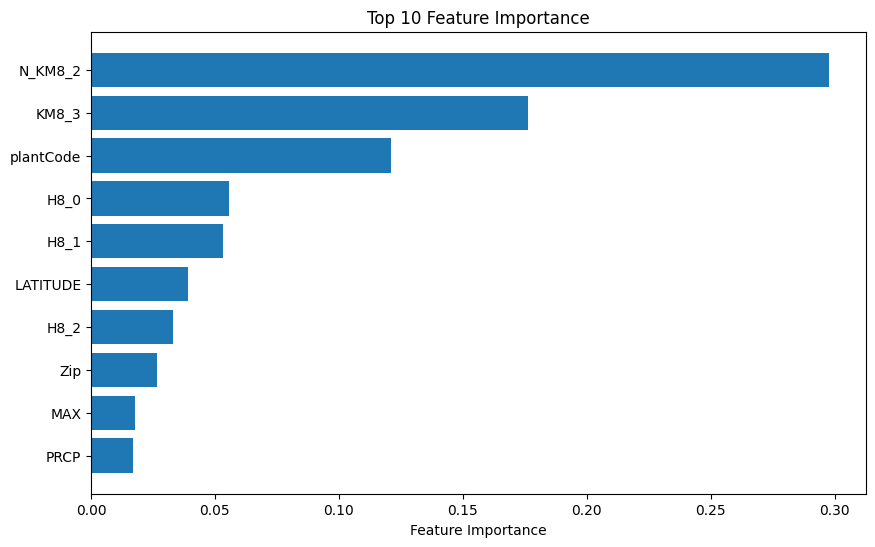

In [17]:
# Define the number of trees in the forest
n_estimators = 100  # Example number of trees, you can change it as needed

# Create a Random Forest model
rf_model = RandomForestRegressor(n_estimators=n_estimators)

# Call the function with the model and other parameters
train_test_and_plot(data, rf_model, start_train, end_train, start_test, end_test, model_features)

C:\Users\nicoesse\AppData\Local\Temp\ipykernel_25388\1824536124.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['state'] = data['state'].astype('category')


Model evaluation:
Mean Squared Error: 499819226136.73895
R-squared: 0.871160641344539


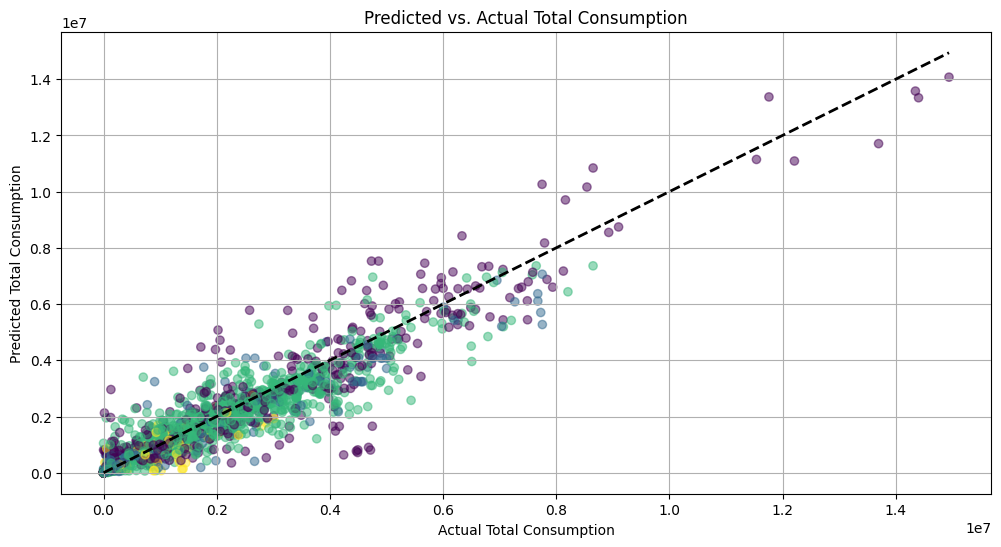

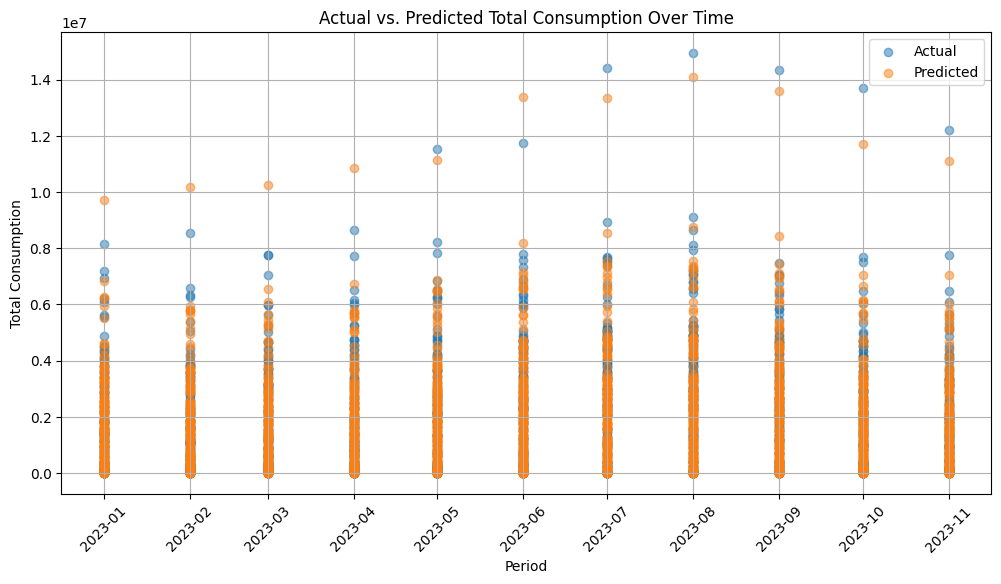

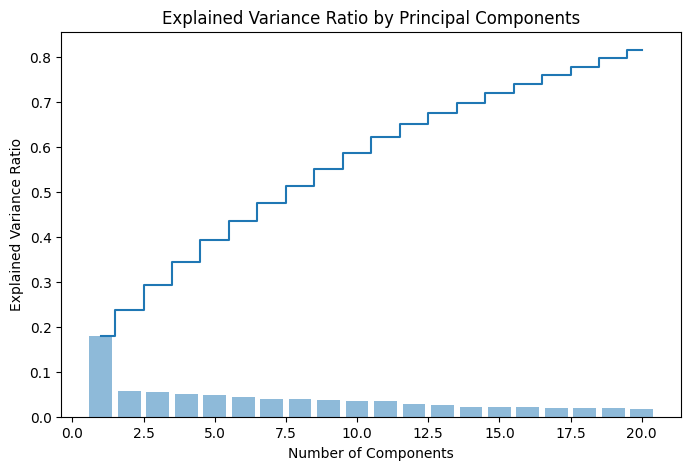

In [18]:
knn_model = KNeighborsRegressor(n_neighbors=6)

# Call the train_test_and_plot function
train_test_and_plot(data, knn_model, start_train, end_train, start_test, end_test, model_features)


C:\Users\nicoesse\AppData\Local\Temp\ipykernel_25388\1824536124.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['state'] = data['state'].astype('category')


Model evaluation:
Mean Squared Error: 994124843574.5433
R-squared: 0.7437425361573341


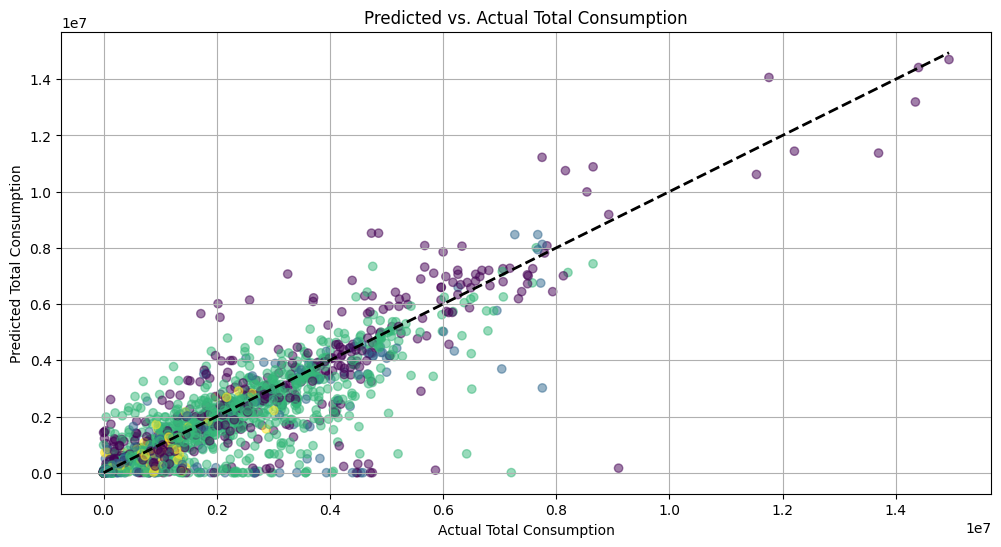

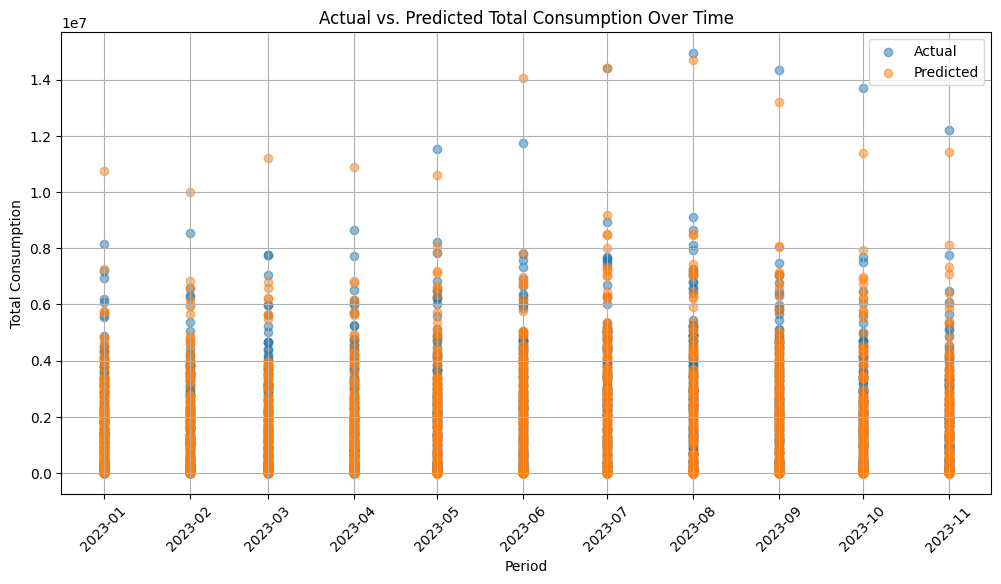

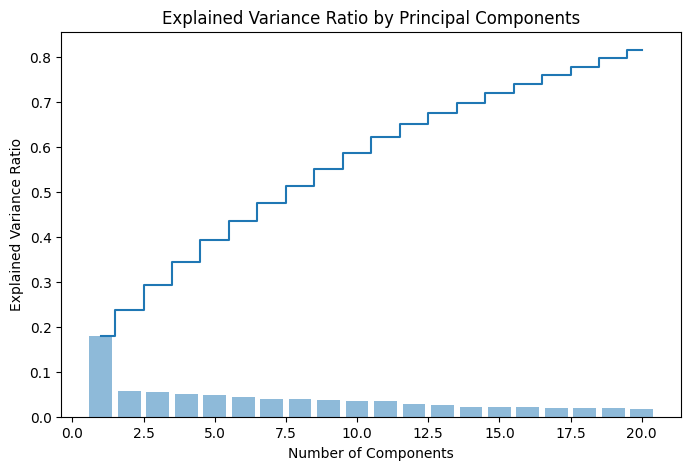

In [19]:
nb_model = GaussianNB()
train_test_and_plot(data, nb_model, start_train, end_train, start_test, end_test, model_features)
